In [1]:
import numpy as np, argparse, pickle
import healpy as hp
import os as oss
import numpy.random as nr

from maps import anis_pta as ap
from maps import utils
from enterprise.signals import anis_coefficients as ac

from math import comb

Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


/home/uwm/nihanpol/miniconda3/envs/enterprise/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
import matplotlib.pyplot as pl
import healpy as hp


In [3]:
import ligo.skymap.plot

In [4]:
seed = 616 #choose a seed for random draws
rng = nr.default_rng(seed)

In [5]:
#Set configuration for square-root spherical harmonic search
lmax = 8
nside = 8

In [6]:
#Set parameters of simulated PTA
n_psrs = 67
n_cc = comb(n_psrs, 2)

In [7]:
print(n_cc)

2211


In [8]:
#Draw random uniform positions for pulsars in PTA
psrs_phi = rng.uniform(low = 0, high = 2 * np.pi, size = n_psrs)
psrs_theta = np.arccos(1 - 2 * rng.uniform(0, 1, size = n_psrs))

In [9]:
#Convert to RA/DEC for plotting
psrs_ra = psrs_phi
psrs_dec = np.pi / 2 - psrs_theta
rad_2_deg = 180 / np.pi

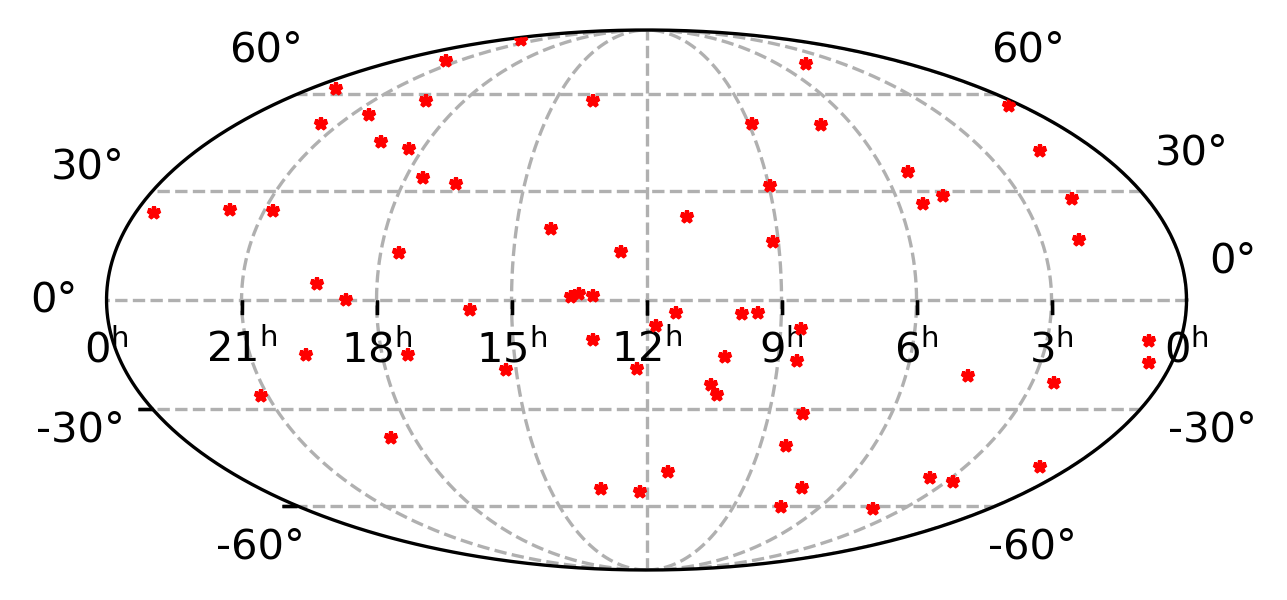

In [10]:
#Make figure here
fig = pl.figure(figsize=(4, 4), dpi=300)

ax = pl.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed',)

for jj in range(n_psrs):
    ax.plot(psrs_ra[jj] * rad_2_deg, psrs_dec[jj] * rad_2_deg, color = 'red', 
            transform=ax.get_transform('world'),
        marker = '*', markersize = 3, ls = '',)
    
pl.show()

In [11]:
#Initiate a PTA object without correlation values to gain access to some useful functions
init_pta = ap.anis_pta(psrs_theta, psrs_phi, [], [], [], nside = nside, l_max = lmax,
                  mode = 'sqrt_power_basis', os = 1, include_pta_monopole = False)

/home/uwm/nihanpol/miniconda3/envs/enterprise/lib/python3.9/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


In [12]:
#Arbitrarily good choice for measurement uncertainty on the correlations
synth_sig = np.repeat(0.1, repeats = n_cc)

#Simulate noisy correlations with mean given by HD curve, and sigma by our choice above
synth_rho = rng.normal(init_pta.get_pure_HD(), synth_sig) 

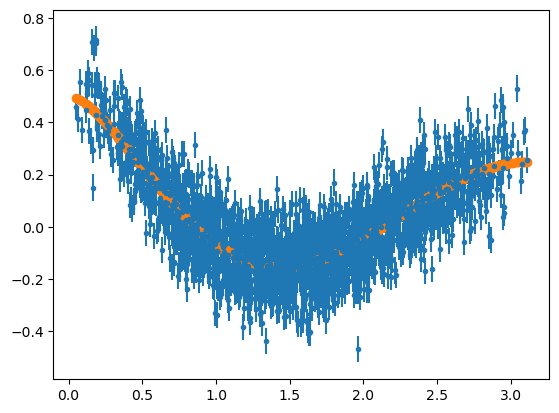

In [13]:
pl.errorbar(init_pta.xi, synth_rho, yerr = synth_sig / 2, ls = '', marker = '.')

pl.plot(init_pta.xi, init_pta.get_pure_HD(), marker = 'o', ls = '')

pl.show()

In [14]:
#Given our "PTA data", setup the anis_pta object with the correlations and their uncertainties

pta = ap.anis_pta(psrs_theta, psrs_phi, init_pta.xi, synth_rho, synth_sig, nside = nside, l_max = lmax, 
              mode = 'sqrt_power_basis')

lm_out = pta.max_lkl_sqrt_power()

In [15]:
lm_out

In [25]:
#Extract best fit b_lm params as a numpy array
lm_params = np.array(list(lm_out.params.valuesdict().values()))

#Convert from the square-root spherical harmonic basis to spherical harmonic basis
lm_clm = utils.convert_blm_params_to_clm(pta, lm_params[1:])

#Calculate the angular power spectrum in the spherical harmonic basis
Cl = utils.angular_power_spectrum(pta, lm_clm) 

#Calculate the best-fit ORF
orf = pta.orf_from_clm(np.append((lm_params[0]), lm_clm))
#orf = np.sum(lm_clm[:, np.newaxis] * pta.Gamma_lm, axis = 0) #Another way to get recovered ORF

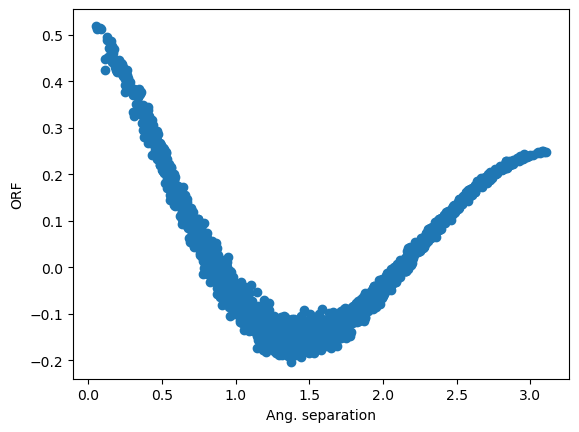

In [37]:
#Plot the best-fit correlations
pl.plot(pta.xi, orf, ls = '', marker = 'o')

pl.xlabel(r"Ang. separation")
pl.ylabel(r"ORF")

pl.show()

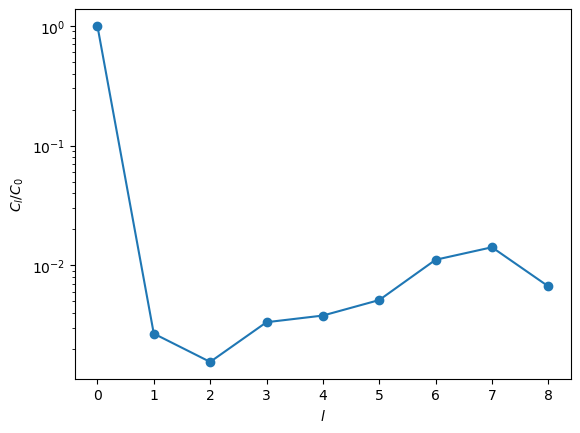

In [27]:
#Plot the angular power spectrum
pl.plot(range(pta.l_max + 1), Cl / Cl[0], marker = 'o')

pl.xlabel(r"$l$")
pl.ylabel(r"$C_{l} / C_{0}$")

pl.yscale('log')

pl.show()

In [33]:
#Calculate the total, isotropic, and anisotropic S/N values

total_sn2, iso_sn2, anis_sn2 = utils.signal_to_noise(pta)

total_sn = np.sqrt(total_sn2)
iso_sn = np.sqrt(iso_sn2)
anis_sn = np.sqrt(anis_sn2)

/home/uwm/nihanpol/miniconda3/envs/enterprise/lib/python3.9/site-packages/enterprise/signals/anis_coefficients.py:194: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  h = hp.alm2map(alm, nside, maxl, verbose=False)


In [34]:
print(total_sn, iso_sn, anis_sn)

68.77941782281948878 68.74727515331189659 2.1024925780615470803


In [35]:
#Translate the c_lm to a sky map
power = 10 ** lm_params[0] * ac.mapFromClm(lm_clm, nside = pta.nside) #Note we model the amplitude in log-space

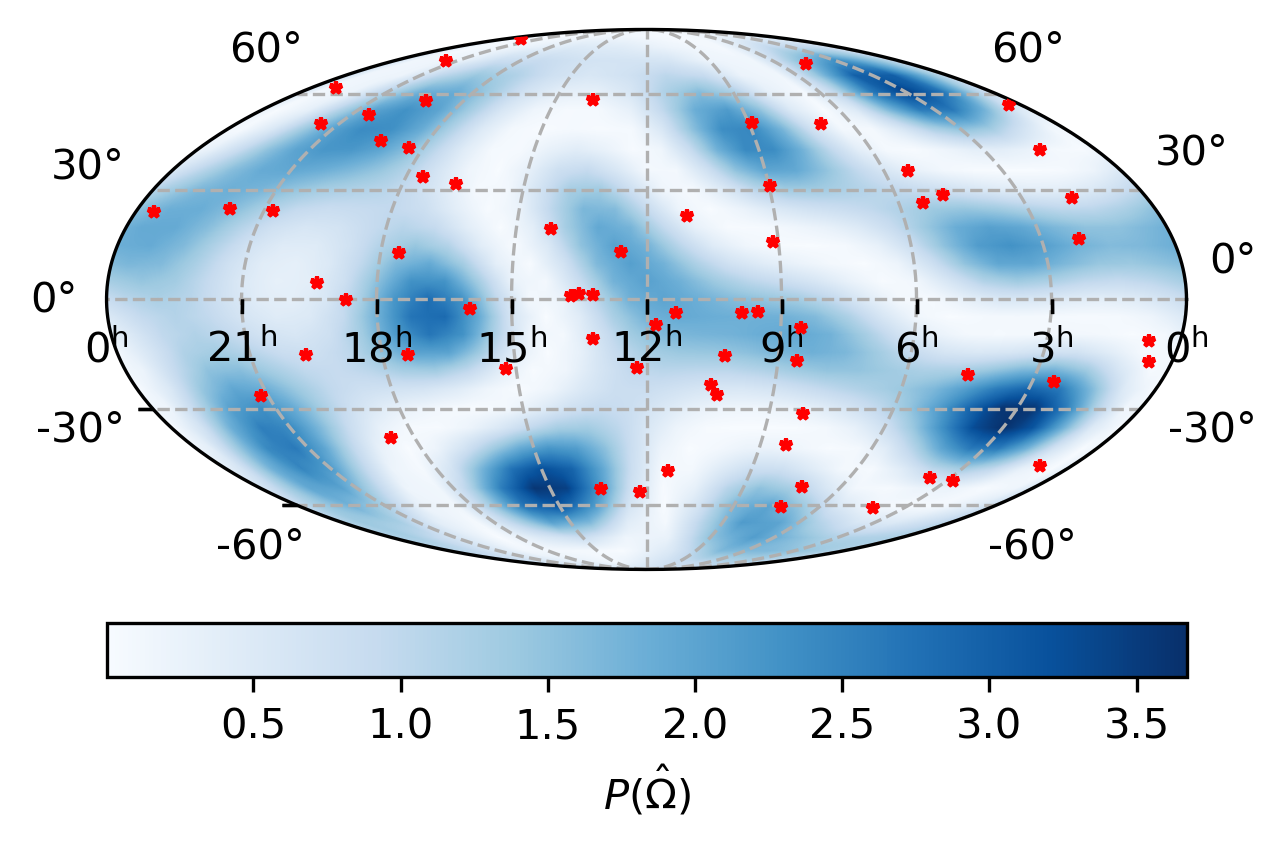

In [36]:
#Make sky map
fig = pl.figure(figsize=(4, 4), dpi=300)

ax = pl.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed',)

cax = ax.imshow_hpx(power, cmap='Blues',)#smooth=1.0*u.deg)
pl.colorbar(cax, orientation='horizontal',pad=0.05, label='$P(\hat\Omega)$')

#Plot the puslars
for jj in range(n_psrs):
    ax.plot(psrs_ra[jj] * rad_2_deg, psrs_dec[jj] * rad_2_deg, color = 'red', 
            transform=ax.get_transform('world'),
        marker = '*', markersize = 3, ls = '',)
    
pl.show()